In [1]:
#Coronavirus is a deadly disease that started in Wuhan China in Dec 2019 and it is named as COVID-19.
#Predicting the COVID-19 confirmed cases by World, Visualisations showed for World and US Confirmed, Deaths and Recoveries. 
#I got the dataset from Kaggle COVID-19 Competition website, GitHub data that was provided by Johns Hopkins University.
#I used SVM Support Vector Machine, Linear Regression and Bayesian Ridge Polynomial Predictions

import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline 

In [2]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/04-18-2020.csv')

In [3]:
cols = confirmed_df.keys()

In [4]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [5]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 

us_cases = [] 
us_deaths = [] 
us_recoveries = [] 

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)

    # case studies 
    us_cases.append(confirmed_df[confirmed_df['Country/Region']=='US'][i].sum())
    us_deaths.append(deaths_df[deaths_df['Country/Region']=='US'][i].sum())
    us_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='US'][i].sum())
   

In [6]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

# confirmed cases
world_daily_increase = daily_increase(world_cases)
us_daily_increase = daily_increase(us_cases)

# deaths
world_daily_death = daily_increase(total_deaths)
us_daily_death = daily_increase(us_deaths)

# recoveries
world_daily_recovery = daily_increase(total_recovered)
us_daily_recovery = daily_increase(us_recoveries)


In [7]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

In [8]:
#future forecasting

days_in_future = 15
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-15]

In [9]:
#Convert string to date
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [10]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, world_cases, test_size=0.03, shuffle=False) 

In [11]:
#Model for predicting # of confirmed cases. I am using support vector machine, bayesian ridge , and linear regression in this example.

# svm_confirmed = svm_search.best_estimator_
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=4, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE: 22727.50530482239
MSE: 855914745.9246875


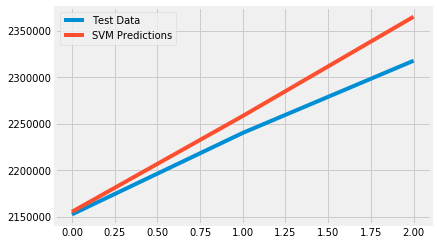

In [12]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [13]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=3)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

bayesian_poly = PolynomialFeatures(degree=4)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train_confirmed)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test_confirmed)
bayesian_poly_future_forcast = bayesian_poly.fit_transform(future_forcast)

In [14]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=True)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 148174.50781263752
MSE: 23071601655.60501


In [15]:
print(linear_model.coef_)

[[ 0.00000000e+00  2.19525978e+04 -9.43101979e+02  1.18763157e+01]]


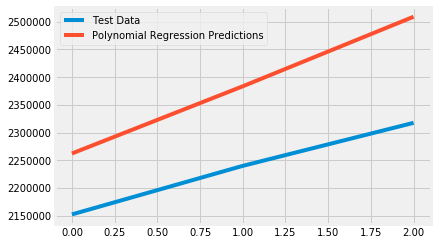

In [16]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

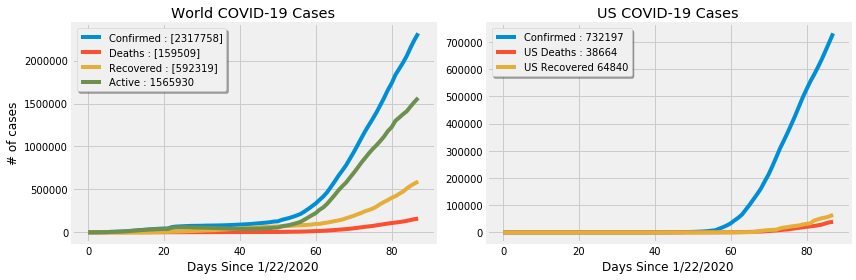

In [197]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].plot(adjusted_dates, world_cases,label="Confirmed : " + str(max(world_cases)))
axes[0].plot(adjusted_dates, total_deaths,label="Deaths : " + str(max(total_deaths)))
axes[0].plot(adjusted_dates, total_recovered,label="Recovered : " + str(max(total_recovered)))
axes[0].plot(adjusted_dates, total_active,label="Active : " + str(max(total_active)))

axes[1].plot(adjusted_dates, us_cases,label="Confirmed : " + str(max(us_cases)))
axes[1].plot(adjusted_dates, us_deaths,label="US Deaths : " +str(max(us_deaths)))
axes[1].plot(adjusted_dates, us_recoveries,label="US Recovered " + str(max(us_recoveries)))

axes[0].set_title('World COVID-19 Cases')
axes[0].set_xlabel('Days Since 1/22/2020')
axes[0].set_ylabel('# of cases')
axes[1].set_title('US COVID-19 Cases')
axes[1].set_xlabel('Days Since 1/22/2020')
axes[0].legend(shadow=True, fancybox=True)
axes[1].legend(shadow=True, fancybox=True)
fig.tight_layout()

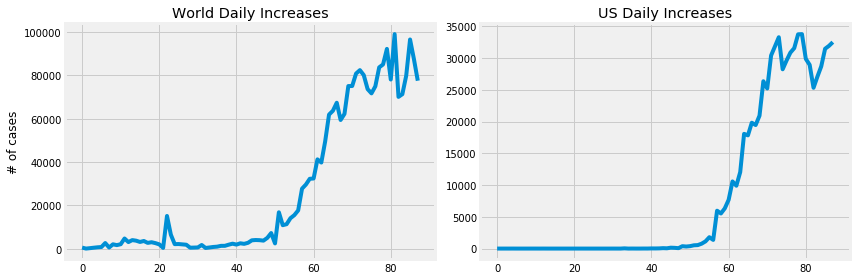

In [198]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].plot(adjusted_dates, world_daily_increase)
axes[1].plot(adjusted_dates, us_daily_increase)

axes[0].set_title('World Daily Increases')
axes[0].set_ylabel('# of cases')
axes[1].set_title('US Daily Increases')
fig.tight_layout()

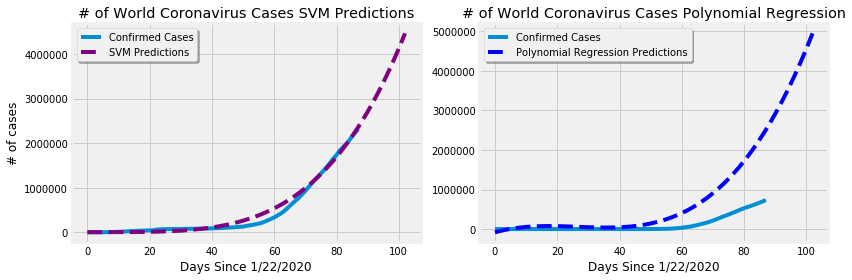

In [208]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].plot(adjusted_dates, world_cases,label='Confirmed Cases')
axes[0].plot(future_forcast, svm_pred, linestyle='dashed', color='purple',label='SVM Predictions')

axes[1].plot(adjusted_dates, us_cases,label='Confirmed Cases')
axes[1].plot(future_forcast, linear_pred, linestyle='dashed', color='blue',label='Polynomial Regression Predictions')

axes[0].set_title('# of World Coronavirus Cases SVM Predictions')
axes[0].set_xlabel('Days Since 1/22/2020')
axes[0].set_ylabel('# of cases')
axes[1].set_title('# of World Coronavirus Cases Polynomial Regression')
axes[1].set_xlabel('Days Since 1/22/2020')
axes[0].legend(shadow=True, fancybox=True)
axes[1].legend(shadow=True, fancybox=True)
fig.tight_layout()

In [91]:
# Future predictions using SVM 
svm_df = pd.DataFrame({'Date': future_forcast_dates[-15:], 'SVM Predicted # of Confirmed Cases Worldwide': np.round(svm_pred[-15:])})
svm_df

,Date,SVM Predicted # of Confirmed Cases Worldwide
0,04/19/2020,2475314.0
1,04/20/2020,2589480.0
2,04/21/2020,2707560.0
3,04/22/2020,2829642.0
4,04/23/2020,2955816.0
5,04/24/2020,3086173.0
6,04/25/2020,3220803.0
7,04/26/2020,3359798.0
8,04/27/2020,3503253.0
9,04/28/2020,3651262.0


In [92]:
# Future predictions using polynomial regression
linear_pred = linear_pred.reshape(1,-1)[0]
svm_df = pd.DataFrame({'Date': future_forcast_dates[-15:], 'Polynomial Predicted # of Confirmed Cases Worldwide': np.round(linear_pred[-15:])})
svm_df

,Date,Polynomial Predicted # of Confirmed Cases Worldwide
0,04/19/2020,2638706.0
1,04/20/2020,2772787.0
2,04/21/2020,2911324.0
3,04/22/2020,3054388.0
4,04/23/2020,3202051.0
5,04/24/2020,3354382.0
6,04/25/2020,3511455.0
7,04/26/2020,3673340.0
8,04/27/2020,3840108.0
9,04/28/2020,4011830.0


In [102]:
unique_countries =  list(latest_data['Country_Region'].unique())

In [103]:
country_confirmed_cases = []
country_death_cases = [] 
country_active_cases = []
country_recovery_cases = []
country_mortality_rate = [] 

no_cases = []
for i in unique_countries:
    cases = latest_data[latest_data['Country_Region']==i]['Confirmed'].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    
# sort countries by the number of confirmed cases
unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_data[latest_data['Country_Region']==unique_countries[i]]['Confirmed'].sum()
    country_death_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Deaths'].sum())
    country_recovery_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Recovered'].sum())
    country_active_cases.append(country_confirmed_cases[i] - country_death_cases[i] - country_recovery_cases[i])
    country_mortality_rate.append(country_death_cases[i]/country_confirmed_cases[i])

In [115]:
country_df = pd.DataFrame({'Country Name': unique_countries, 'Number of Confirmed Cases': country_confirmed_cases,
                          'Number of Deaths': country_death_cases, 'Number of Recoveries' : country_recovery_cases, 
                          'Number of Active Cases' : country_active_cases,
                          'Mortality Rate': country_mortality_rate})

# number of cases per country/region

#country_df.style.background_gradient(cmap='Grens')
country_df.iloc[0:1]

,Country Name,Number of Confirmed Cases,Number of Deaths,Number of Recoveries,Number of Active Cases,Mortality Rate
0,US,732197,38664,64840,628693,0.052805


In [116]:
unique_provinces =  list(latest_data['Province_State'].unique())

In [117]:
province_confirmed_cases = []
province_country = [] 
province_death_cases = [] 
province_recovery_cases = []
province_mortality_rate = [] 

no_cases = [] 
for i in unique_provinces:
    cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
    if cases > 0:
        province_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    unique_provinces.remove(i)
    
unique_provinces = [k for k, v in sorted(zip(unique_provinces, province_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_provinces)):
    province_confirmed_cases[i] = latest_data[latest_data['Province_State']==unique_provinces[i]]['Confirmed'].sum()
    province_country.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Country_Region'].unique()[0])
    province_death_cases.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Deaths'].sum())
    province_recovery_cases.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Recovered'].sum())
    province_mortality_rate.append(province_death_cases[i]/province_confirmed_cases[i])


In [119]:
# Only show 10 countries with the most confirmed cases, the rest are grouped into the other category
visual_unique_countries = [] 
visual_confirmed_cases = []
others = np.sum(country_confirmed_cases[10:])

for i in range(len(country_confirmed_cases[:10])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(country_confirmed_cases[i])
    
visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

In [174]:
    c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
       
    # Plotting countries with regional data using a pie chart 

    regions = list(latest_data[latest_data['Country_Region']=='US']['Province_State'].unique())
    confirmed_cases = []
    no_cases = [] 
    for i in regions:
        cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
        if cases > 0:
            confirmed_cases.append(cases)
        else:
            no_cases.append(i)

    # remove areas with no confirmed cases
    for i in no_cases:
        regions.remove(i)

    # only show the top 10 states
    regions = [k for k, v in sorted(zip(regions, confirmed_cases), key=operator.itemgetter(1), reverse=True)]

    for i in range(len(regions)):
        confirmed_cases[i] = latest_data[latest_data['Province_State']==regions[i]]['Confirmed'].sum()  
    
    # additional province/state will be considered "others"
    
    if(len(regions)>10):
        regions_10 = regions[:10]
        regions_10.append('Others')
        confirmed_cases_10 = confirmed_cases[:10]
        confirmed_cases_10.append(np.sum(confirmed_cases[10:]))
        
        c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
   
       
        

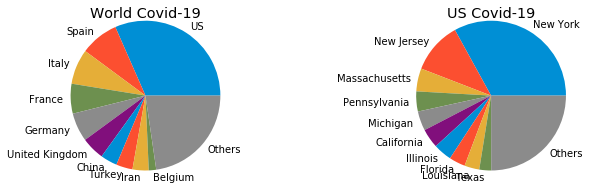

In [175]:
fig = plt.figure()

ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)
ax1.pie(visual_confirmed_cases, labels=visual_unique_countries, radius = 1.3)

ax2 = fig.add_axes([.8, .0, .5, .5], aspect=1)
ax2.pie(confirmed_cases_10, labels=regions_10, radius = 1.3)

ax1.set_title('World Covid-19')
ax2.set_title('US Covid-19')
plt.show()

In [211]:
# number of cases per province/state/city
province_df = pd.DataFrame({'Province/State Name': unique_provinces, 'Country': province_country, 
                          'Number of Confirmed Cases': province_confirmed_cases,
                          'Number of Deaths': province_death_cases, 
                          'Number of Recoveries' : province_recovery_cases,
                          'Mortality Rate': province_mortality_rate})
# number of cases per country/region

province_df.style.background_gradient(cmap='coolwarm')

,Province/State Name,Country,Number of Confirmed Cases,Number of Deaths,Number of Recoveries,Mortality Rate
0,New York,US,241712,17671,0,0.0731077
1,New Jersey,US,81420,4070,0,0.0499877
2,Hubei,China,68128,4512,63494,0.0662283
3,Massachusetts,US,36372,1404,0,0.0386011
4,Pennsylvania,US,31652,1042,0,0.0329205
5,Michigan,US,30791,2308,0,0.074957
6,California,US,30491,1140,0,0.0373881
7,Illinois,US,29160,1259,0,0.0431756
8,Florida,US,25492,748,0,0.0293425
9,Louisiana,US,23580,1267,0,0.053732


In [212]:
# Only show 10 provinces with the most confirmed cases, the rest are grouped into the other category
visual_unique_provinces = [] 
visual_confirmed_cases2 = []
others = np.sum(province_confirmed_cases[10:])
for i in range(len(province_confirmed_cases[:10])):
    visual_unique_provinces.append(unique_provinces[i])
    visual_confirmed_cases2.append(province_confirmed_cases[i])

visual_unique_provinces.append('Others')
visual_confirmed_cases2.append(others)

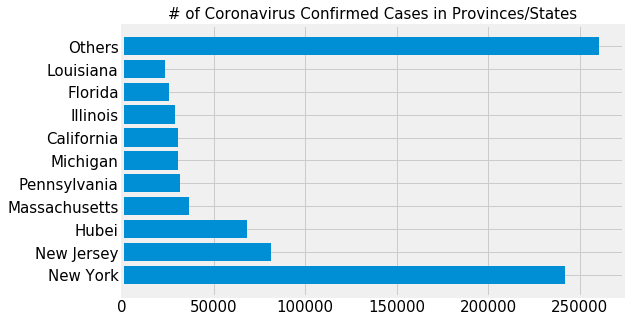

In [232]:
    plt.figure(figsize=(8, 5))
    plt.barh(visual_unique_provinces, visual_confirmed_cases2)
    plt.title('# of Coronavirus Confirmed Cases in Provinces/States', size=15)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.show()